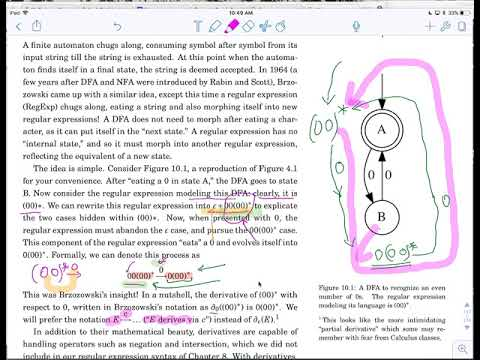

In [1]:
# This Youtube video walks through this notebook

from IPython.display import YouTubeVideo
YouTubeVideo('xGvCjoWemWg')

# Asg4: Context-free Parsing and Derivative Scanning

This Jove file covers two topics. The first, context-free parsing, helps us design a parser for regular expressions. In your assignment, you are to experiment with context-free parsing as well as derivative scanning.

## Context-free Parsing

We will present the parser for regular expressions

In [2]:
import sys
sys.path[0:0] = ['../..','../../3rdparty'] # Put these at the head of the search path

from lex import lex
from yacc import yacc
from jove.StateNameSanitizers import ResetStNum, NxtStateStr
from jove.SystemImports       import *

You may use any of these help commands:
help(ResetStNum)
help(NxtStateStr)



### Token definitions

This is the lexer for REs. We begin with token definitions

In [3]:
tokens = ('EPS','STR','LPAREN','RPAREN','PLUS','STAR') #, 'NOT', 'AND')

# Tokens
t_PLUS    = r'\+'
t_STAR    = r'\*'
t_LPAREN  = r'\('
t_RPAREN  = r'\)'
t_EPS     = r'\'\'|\"\"'  # Not allowing @ for empty string anymore! # t_EPS = r'\@'
t_STR     = r'[a-zA-Z0-9]'
#t_NOT     = A4J: ADD THE REGULAR EXPRESSION FOR NEGATION HERE
#t_AND     = A4J: ADD THE REGULAR EXPRESSION FOR CONJUNCTION HERE

# Ignored characters
t_ignore = " \t"

def t_newline(t):
    r'\n+'
    t.lexer.lineno += t.value.count("\n")
    
def t_error(t):
    print("Illegal character '%s'" % t.value[0])
    t.lexer.skip(1)
    
# Build the lexer if necessary
# lex()

### These parsing rules specify many things. 

We begin with operator precedence rules that are essentially to help the "LALR parser" (also known as the bottom-up parser) resolve 'shift-reduce conflicts'.

In [4]:
# Parsing rules

# A4J: Suggested new precedence rules for AND and NOT are in comments below.
# Uncomment the AND and NOT lines in your extension
# 
precedence = (
   ('left','PLUS'),
#   ('left', 'AND'),
   ('left','STAR'),
#   ('right','NOT')
   )

### CFG productions and semantic actions

These Python functions whose names begin with "p_" house (1) the CFG production rules within their documentation strings. (2) the semantic actions within their body. The semantic actions can refer to grammar symbol attributes within CFG productions. We will explain one of these rules now.

Take the rules 

 expression -> expression PLUS catexp
 expression -> catexp
 
1) This function defines the first production rule

def p_expression_plus(t):

   a) This comment string expresses the production rule
   
    '''expression : expression PLUS catexp'''
    
   b) This line below tells us that the occurrence of 'expression' on
      the left-hand side is marked t[0], and its value is determined by
      applying function attrDyadicInfix onto its three arguments below.
      Here, t[1] is the attribute of 'expression' coming after the colon (:)
      and the attribute of catexp is t[3]
      
    t[0] = attrDyadicInfix("+", t[1], t[3])    
    
2) This function expresses the second related production rule where the
   basis case 
    
def p_expression_plus1(t):
    '''expression : catexp'''

    t[0] = t[1]  

In [5]:
def p_expression_plus(t):
    'expression : expression PLUS catexp'
    #
    t[0] = attrDyadicInfix("+", t[1], t[3])    
    
def p_expression_plus1(t):
    'expression : catexp'
    #
    t[0] = t[1]  

In [6]:

def p_expression_cat(t):
    'catexp :  catexp andexp'
    #
    t[0] = attrDyadicInfix(".", t[1], t[2])

def p_expression_cat1(t):
    'catexp :  andexp'
    #
    t[0] = t[1]  

'''
def p_expression_ordy(t):
    'andexp : andexp AND ordyexp'
    #
    t[0] = attrDyadicInfix("&", t[1], t[3])
'''

def p_expression_ordy1(t):
    'andexp : ordyexp'
    #
    t[0] = t[1]

# We employ field 'ast' of the dict to record the abstract syntax tree. 
# Field 'dig' holds a digraph. It too is a dict. 
# Its fields are nl for the node list and el for the edge list

def p_expression_ordy_star(t):
    'ordyexp : ordyexp STAR'
    #
    ast = ('*', t[1]['ast'])

    nlin = t[1]['dig']['nl']
    elin = t[1]['dig']['el']
    
    rootin = nlin[0]

    root = NxtStateStr("R*_") 
    right = NxtStateStr("*_")

    t[0] = {'ast' : ast,
            'dig' : {'nl' : [root] + nlin + [right], # this order important for proper layout!
                     'el' : elin + [ (root, rootin),
                                     (root, right) ]
                    }}

'''
def p_expression_ordy_not(t):
    'ordyexp : NOT ordyexp'
    #
    ast  = ('!', t[2]['ast'])
    
    nlin = t[2]['dig']['nl']
    elin = t[2]['dig']['el']
    
    rootin = nlin[0]

    root = NxtStateStr("!R_") 
    left = NxtStateStr("!_")

    t[0] = {'ast' : ast,
            'dig' : {'nl' : [ root, left ] + nlin, # this order important for proper layout!
                     'el' : elin + [ (root, left),
                                     (root, rootin) ]
                    }}
'''
    
def p_expression_ordy_paren(t):
    'ordyexp : LPAREN expression RPAREN'
    #
    ast  = t[2]['ast']
    
    nlin = t[2]['dig']['nl']
    elin = t[2]['dig']['el']
    
    rootin = nlin[0]
    
    root = NxtStateStr("(R)_")
    left = NxtStateStr("(_")
    right= NxtStateStr(")_")
    
    t[0] = {'ast' : ast,
            'dig' : {'nl' : [root, left] + nlin + [right], #order important f. proper layout!
                     'el' : elin + [ (root, left),
                                     (root, rootin),
                                     (root, right) ]
                    }}

def p_expression_ordy_eps(t):
    'ordyexp : EPS'
    #
    strn = '@'
    ast  = ('@', strn)           
    t[0] = { 'ast' : ast,
             'dig' : {'nl' : [ strn + NxtStateStr("_") ],
                      'el' : []
                     }}          
    
def p_expression_ordy_str(t):
    'ordyexp : STR'
    #
    strn = t[1]
    ast  = ('str', strn)
    t[0] = {'ast' : ast,
            'dig' : {'nl' : [ strn + NxtStateStr("_") ],
                     'el' : [] 
                    }}

def p_error(t):
    print("Syntax error at '%s'" % t.value)

#--
    
def attrDyadicInfix(op, attr1, attr3):
    ast  = (op, (attr1['ast'], attr3['ast']))
    
    nlin1 = attr1['dig']['nl']
    nlin3 = attr3['dig']['nl']
    nlin  = nlin1 + nlin3
    
    elin1 = attr1['dig']['el']
    elin3 = attr3['dig']['el']
    elin  = elin1 + elin3
    
    rootin1 = nlin1[0]
    rootin3 = nlin3[0]    
    
    root   = NxtStateStr("R1"+op+"R2"+"_") # NxtStateStr("$_")
    left   = rootin1
    middle = NxtStateStr(op+"_")
    right  = rootin3
    
    return {'ast' : ast,
            'dig' : {'nl' : [ root, left, middle, right ] + nlin,
                     'el' : elin + [ (root, left),
                                     (root, middle),
                                     (root, right) ]
                     }}

#===
# This is the main function in this Jove file. Give
#===

def parseRE(s):
    """In: a string s containing a regular expression.
       Out: An attribute triple consisting of
            1) An abstract syntax tree suitable for processing in the derivative-based scanner
            2) A node-list for the parse-tree digraph generated. Good for drawing a parse tree 
               using the drawPT function below
            3) An edge list for the parse-tree generated (again good for drawing using the
               drawPT function below)
    """
    mylexer  = lex()
    myparser = yacc()
    pt = myparser.parse(s, lexer = mylexer)
    return (pt['ast'], pt['dig']['nl'], pt['dig']['el'])

In [7]:
def drawPT(ast_nl_el, comment="PT"):
    """Given an (ast, nl, el) triple where nl is the node and el the edge-list,
       draw the Parse Tree by returning a dot object.
    """
    (ast, nl, el) = ast_nl_el
    print("Drawing AST for ", ast)
    dotObj_pt = Digraph(comment)
    dotObj_pt.graph_attr['rankdir'] = 'TB'
    for n in nl:
        prNam = n.split('_')[0]
        dotObj_pt.node(n, prNam, shape="oval", peripheries="1")
    for e in el:
        dotObj_pt.edge(e[0], e[1])
    return dotObj_pt

# Exercise: Study of Parsing by Drawing Parse Trees

** Question Q1(a): ** Some simple parse-tree examples are now given. Please produce three more interesting-looking parser-trees of your own. They can be anything, but ensure that you understand the trees generated. Write two short sentences describing each such parse-tree produced. Try to limit yourself to about eight leaf nodes and about the same number of operators (rough guideline only).

Drawing AST for  ('@', '@')


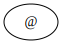

In [8]:
drawPT(parseRE("''"))

Drawing AST for  ('str', '1')


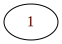

In [9]:
drawPT(parseRE("1"))

Drawing AST for  ('*', ('.', (('*', ('str', '0')), ('*', ('str', '1')))))


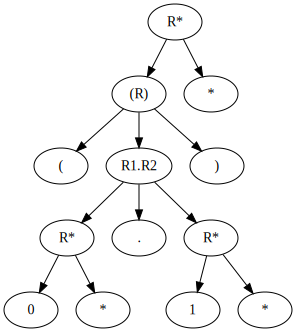

In [10]:
drawPT(parseRE("(0*1*)*"))

** Your answer for Q1(a) below **

# Exercise: Produce the Parse Tree for an RE, and Explain 

** Q1(b): ** Draw the parse tree for "0+11*" and explain its shape. Does it implement precedences that you expect "naturally"?

Drawing AST for  ('+', (('str', '0'), ('.', (('str', '1'), ('*', ('str', '1'))))))


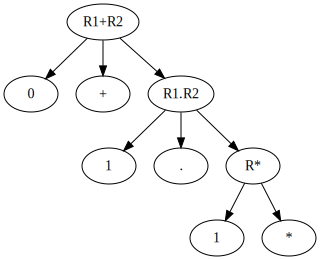

In [11]:
drawPT(parseRE("0+11*"))

** Your answer for Q1(b) here: ** 

# Exercise : RE parsing : Precedences

Q1(c): Create variants of the expression "0+11*" by putting parentheses, and describe the parse-trees obtained. For example, calling the above RE R1, we have

* R1 = "0+11*"

* R2 = "(0+1)1*" is one variant.

Similarly, produce two other variants, calling them R3 and R4 merely by placing parentheses differently.

* Argue that R1 through R4 denote different languages

** Your answer for Q1(c) below **

# Produce parse-trees for extended REs

** Q1(d): **  Turn on the parsing rules for "!" and "&". Test these three regular expressions on the following REs

* RE with * and ! : "a!b*"

* RE with & involved : "cd&ef"

* RE with & and + involved : "a+b&c+d"


** Your answer for Q1(d) below **

# Derivative-based Pattern Matching

In [12]:
#=== Now comes derivMatch as illustration of RE Derivative scanning

# These four functions are simple extractors of the operator and arguments

def opr(E):
    """Retrieves the operator of an expression.
    """
    return E[0]

def arg1(E):
    """Retrieves the first argument of a binary operator-based expression.
    """
    return E[1][0]

def arg2(E):
    """Retrieves the second argument of a binary operator-based expression.
    """
    return E[1][1]

def arg(E):
    """Retrieves the only argument of a unary operator-based expression.
    """
    return E[1]

def nullable(E):
    """This is the nullability test defined in Chapter 10.
    """
    if (opr(E) == "str") :
        return False
    elif (opr(E) == '@') :
        return True
    elif (opr(E) == "mty") :
        return False
    elif (opr(E) == "*"):
        return True
#    elif (opr(E) == "!"):
#        return not nullable(arg(E))
    elif (opr(E) == '+') :
        return nullable(arg1(E)) or nullable(arg2(E))
    elif (opr(E) == '.') :
        return nullable(arg1(E)) and nullable(arg2(E))
#    elif (opr(E) == '&') :
#        return nullable(arg1(E)) and nullable(arg2(E))
    else:
        return "???"    

def dv(E, c):
    """This function computes the derivative
       of a regular expression E with respect
       to character "c".
    """
    if (opr(E) == "str") :
        if (arg(E) == c):
            return ('@', '@')
        else:
            return ("mty", "mty")
    elif (opr(E) == '@') :
        return ("mty", "mty")
    elif (opr(E) == "mty") :
        return ("mty", "mty")
    elif (opr(E) == "*"):
        return (".", (dv(arg(E), c), E))
    elif (opr(E) == "!"):
        return ("!", dv(arg(E), c))
    elif (opr(E) == '+') :
        return ("+", (dv(arg1(E), c), dv(arg2(E), c)))
    elif (opr(E) == '&') :
        return ("&", (dv(arg1(E), c), dv(arg2(E), c)))
    elif (opr(E) == '.') :
        if nullable(arg1(E)):
            return ("+", ( ('.', (dv(arg1(E), c), arg2(E))), dv(arg2(E), c) ))
        else:
            return ('.', (dv(arg1(E), c), arg2(E)))
    else:
        return "???"        

def matches(w, E):
    if w=="":
        return nullable(E)
    else:
        derivative = dv(E, w[0])
        return matches(w[1:], derivative)

# Testing Derivative-based Parsing

## Testing Nullability

A regular expression is nullable if its language contains epsilon.
Regular-expression based pattern-matching works as follows:

* Keep obtaining the derivatives of a given RE under the characters comprising a string

* When the string is empty, check whether the RE is nullable.

In [13]:
(E, nl, el) = parseRE("''")
nullable(E)

True

In [14]:
(E, nl, el) = parseRE("c")
nullable(E)

False

In [15]:
(E, nl, el) = parseRE("c*")
nullable(E)

True

In [16]:
(E, nl, el) = parseRE("!c*")
nullable(E)

Illegal character '!'


True